In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import ttest_ind

### Load and format Ghent University Hospital dataset

In [4]:
import os
abs_dir = os.getcwd()
rel_dir = os.path.join(abs_dir, '../data/raw/hospital/UZGent_full.xlsx')
df = pd.read_excel(rel_dir, sheet_name="Sheet1")

In [5]:
def isnat(your_datetime):
    dtype_string = str(your_datetime.dtype)
    if 'datetime64' in dtype_string or 'timedelta64' in dtype_string:
        return your_datetime.view('i8') == np.datetime64('NAT').view('i8')
    return False  # it can't be a NaT if it's not a dateime

In [6]:
age=[]
sex=[]
outcome=[]
stay_type=[]
dc=[]
dICU=[]
dICUrec=[]
n=[]

# drop empty entries in Outcome status/date from dataframe
df['Outcome status'].replace('', np.nan, inplace=True)
df['Outcome date'].replace('', np.nan, inplace=True)
df.dropna(subset=['Outcome status'], inplace=True)
df.dropna(subset=['Outcome date'], inplace=True)

# Conversion of dates to uniform datatype
df['Admission date IZ'] = df['Admission date IZ'].values.astype('datetime64[D]')
df['Stopdate IZ'] = df['Stopdate IZ'].values.astype('datetime64[D]')
df['Outcome date'] = df['Outcome date'].values.astype('datetime64[D]')

id_group=df.groupby(['UZCOVID_id'])
for g_idx, group in id_group:
    # filter out 'transfer/revalidatie' in column 'Outcome status'
    if (group['Outcome status'].values[0] != 'transfer/revalidatie'):
        # add patient age
        age.append(group['Age'].values[0])        
        # add patient sex
        if group['Sex'].values[0] == 'Male':
            sex.append('M')
        else:
            sex.append('F')
        # check if patient has recovered
        if group['Outcome status'].values[0] != 'overleden':
            outcome.append('R')
        else:
            outcome.append('D')
        # if the admission date to IZ has a value do,
        if not isnat(group['Admission date IZ'].values[0]):
            # patient had an ICU stay
            stay_type.append('ICU')
            # length of stay in ICU
            dICU.append((group['Stopdate IZ'].values[0] - group['Admission date IZ'].values[0]).astype('timedelta64[D]').astype(int))
            # length of stay after ICU
            dICUrec.append((group['Outcome date'].values[0] - group['Stopdate IZ'].values[0]).astype('timedelta64[D]').astype(int))
            # length of stay before ICU
            if (group['Admission date IZ'].values[0] - group['Admission date UZ Gent'].values[0]).astype('timedelta64[D]').astype(int) >= 0:
                dc.append((group['Admission date IZ'].values[0] - group['Admission date UZ Gent'].values[0]).astype('timedelta64[D]').astype(int))
            else:
                dc.append(0)
        else:
            # patient had a Cohort only stay
            stay_type.append('Cohort only')
            dc.append((group['Outcome date'].values[0] - group['Admission date UZ Gent'].values[0]).astype('timedelta64[D]').astype(int))
            dICU.append(0)
            dICUrec.append(0)
            
UZG_dict={
    'age': age,
    'sex': sex,
    'stay_type': stay_type,
    'outcome': outcome,
    'dC': dc,
    'dICU': dICU,
    'dICUrec': dICUrec
}

UZG_df = pd.DataFrame(UZG_dict)
UZG_df.tail()

,age,sex,stay_type,outcome,dC,dICU,dICUrec
172,52,F,Cohort only,R,16,0,0
173,51,M,Cohort only,R,3,0,0
174,51,M,ICU,R,5,2,6
175,51,M,Cohort only,R,11,0,0
176,51,M,Cohort only,R,1,0,0


### Time Cohort --> ICU

In [7]:
d_C_to_ICU = UZG_df[(UZG_df.stay_type == 'ICU')].dC.mean()
print(d_C_to_ICU)

1.275


### Load and format AZMM dataset

In [8]:
import os
abs_dir = os.getcwd()
rel_dir = os.path.join(abs_dir, '../data/raw/hospital/AZmariaMiddelares.xlsx')
df = pd.read_excel(rel_dir, sheet_name="Sheet1")

In [19]:
patients_dict={}
id_group=df.groupby(['Opnamenummer'])
for g_idx, group in id_group:
    # filter out 'ZZ-Niet ingevuld' in column 'Bestemming'
    if group['Bestemming na ontslag'].values[0] != 'ZZ-Niet ingevuld':
        # add patient ID
        patients_dict.update({g_idx: {}})
        # add patient age
        patients_dict[g_idx].update({'Age':group['Leeftijd'].values[0]})
        # add patient sex
        if group['Geslacht'].values[0] == 'Man':
            patients_dict[g_idx].update({'Sex': 'M'})
        else:
            patients_dict[g_idx].update({'Sex': 'F'})
        # add patient recovered or dead
        if group['Bestemming na ontslag'].values[0] != 'Overleden':
            patients_dict[g_idx].update({'Status': 'R'})
        else:
            patients_dict[g_idx].update({'Status': 'D'})
        # add patients wards as list, calculate total length of emergency room and buffer
        wards=[]
        lengths=[]
        for r_idx, row in group.iterrows():
            if (group['Afdeling'][r_idx] != 'Spoed' and group['Afdeling'][r_idx] != 'Bufferafdeling'):
                wards.append(group['Afdeling'][r_idx])
                lengths.append(group['Ligduur'][r_idx])
        patients_dict[g_idx].update({'Wards': wards[::-1]})
        patients_dict[g_idx].update({'Lengths': lengths[::-1]})
        ER_buffer=[]
        l=0
        for r_idx, row in group.iterrows():
            if (group['Afdeling'][r_idx] == 'Spoed' or group['Afdeling'][r_idx] == 'Bufferafdeling'):
                l=l+group['Ligduur'][r_idx]
            ER_buffer.append(l)
        patients_dict[g_idx].update({'ER_buffer': l})

193 1.0659991243523315


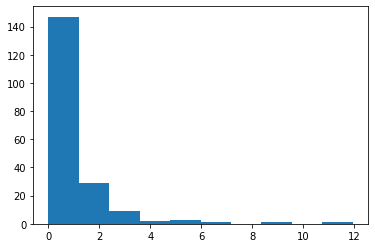

In [22]:
ER_buffer=[]
for ID in patients_dict:
    ER_buffer.append(patients_dict[ID]['ER_buffer'])
plt.hist(ER_buffer)
print(len(ER_buffer),np.mean(ER_buffer))

### Convert to a better format

In [8]:
for ID in patients_dict:
    # First append the age and sex of the patient
    age.append(patients_dict[ID]['Age'])
    sex.append(patients_dict[ID]['Sex'])
    # Then check if the patient recovered or not
    if patients_dict[ID]['Status'] == 'R':
        outcome.append('R')
    else:
        outcome.append('D')
    # if any of the patients entries was in an ICU ward do,
    if any(patients_dict[ID]['Wards'][idx] == 'IZ' for idx,ward in enumerate(patients_dict[ID]['Wards'])):
        stay_type.append('ICU')
        # loop over wards and indices
        for idx,ward in enumerate(patients_dict[ID]['Wards']):
            # get index of ICU in wards
            if ward == 'IZ':
                # if recovered
                if patients_dict[ID]['Status'] == 'R':
                    # check if patient had a recovery stay in cohort or not and extract total length
                    if len(patients_dict[ID]['Wards'])-1 > idx:
                        dICUrec.append(sum(patients_dict[ID]['Lengths'][idx+1:]))
                    else:
                        dICUrec.append(0)
                    # add patient data to lists
                    dc.append(0)
                    dICU.append(patients_dict[ID]['Lengths'][idx])
                    
                # if dead
                else:
                    # check if patient had a recovery stay in cohort or not and extract total length
                    if len(patients_dict[ID]['Wards'])-1 > idx:
                         dICUrec.append(sum(patients_dict[ID]['Lengths'][idx+1:]))
                    else:
                        dICUrec.append(0)
                    # add patient data to lists
                    dc.append(0)
                    dICU.append(patients_dict[ID]['Lengths'][idx])
    # if the patient didn't stay in ICU but did stay in Cohort
    elif any( (patients_dict[ID]['Wards'][idx] == 'Cohort-afdeling D501') or (patients_dict[ID]['Wards'][idx] == 'Cohort-afdeling D601') for idx,ward in enumerate(patients_dict[ID]['Wards'])):
        stay_type.append('Cohort only')
        dc.append(sum(patients_dict[ID]['Lengths']))
        dICU.append(0)
        dICUrec.append(0)
    else:
        stay_type.append('ER only')
        dc.append(0)
        dICU.append(0)
        dICUrec.append(0)

total_dict={
    'age': age,
    'sex': sex,
    'stay_type': stay_type,
    'outcome': outcome,
    'dC': dc,
    'dICU': dICU,
    'dICUrec': dICUrec
}

total_df = pd.DataFrame(total_dict)
total_df.tail()

,age,sex,stay_type,outcome,dC,dICU,dICUrec
365,82,F,Cohort only,R,5.083331,0.00000,0.000000
366,73,F,ICU,R,0.000000,0.89375,9.095832
367,90,M,Cohort only,R,1.856249,0.00000,0.000000
368,55,F,Cohort only,R,3.697916,0.00000,0.000000
369,75,F,ER only,R,0.000000,0.00000,0.000000


### Make an age-stratified parameter dataframe

In [9]:
age_classes = pd.IntervalIndex.from_tuples([(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,80),(80,120)], 
                                           closed='left')
total_df['age_class'] = pd.cut(total_df.age, bins=age_classes)

In [10]:
hospital_parameters_age = pd.DataFrame(index=age_classes, 
                                   columns=['sample_size','c','m0','m0_{ICU}','m0_{C}','dC','dC_R','dC_D','dICU','dICU_R','dICU_D','dICUrec'])

In [11]:
hospital_parameters_age['sample_size']=total_df.groupby(by='age_class').apply(lambda x: x.age.count())

In [12]:
# Fraction of patients that doesn't need ICU
hospital_parameters_age['c'] = total_df.groupby(by='age_class').apply(
                                lambda x: x[x.stay_type=='Cohort only'].age.count()/
                                          x[x.stay_type.isin(['ICU', 'Cohort only'])].age.count())
hospital_parameters_age['c']=hospital_parameters_age['c'].fillna(1)

# Mortality in ICU
hospital_parameters_age['m0']=total_df.groupby(by='age_class').apply(
                                lambda x: x[( (x.outcome=='D'))].age.count()/
                                          x[x.stay_type.isin(['ICU','Cohort only'])].age.count())

# Mortality in ICU
hospital_parameters_age['m0_{ICU}']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='ICU') & (x.outcome=='D'))].age.count()/
                                          x[x.stay_type.isin(['ICU'])].age.count())

# Mortality in Cohort
hospital_parameters_age['m0_{C}']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='Cohort only') & (x.outcome=='D'))].age.count()/
                                          x[x.stay_type.isin(['Cohort only'])].age.count())
hospital_parameters_age[['m0','m0_{ICU}','m0_{C}']]=hospital_parameters_age[['m0','m0_{ICU}','m0_{C}']].fillna(0)

# Hospitalisation length in Cohort
hospital_parameters_age['dC']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='Cohort only'))].dC.mean())

# Hospitalisation length in Cohort if recovered
hospital_parameters_age['dC_R']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='Cohort only') & (x.outcome=='R'))].dC.mean())

# Hospitalisation length in Cohort when deceased
hospital_parameters_age['dC_D']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='Cohort only') & (x.outcome=='D'))].dC.mean())

# Hospitalisation length in ICU
hospital_parameters_age['dICU']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='ICU'))].dICU.mean())

# Hospitalisation length in ICU if recovered
hospital_parameters_age['dICU_R']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='ICU') & (x.outcome=='R'))].dICU.mean())

# Hospitalisation length in ICU when deceased
hospital_parameters_age['dICU_D']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='ICU') & (x.outcome=='D'))].dICU.mean())

# Hospitalisation length in ICU when deceased
hospital_parameters_age['dICU_D']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='ICU') & (x.outcome=='D'))].dICU.mean())

# Hospitalisation length in ICU when deceased
hospital_parameters_age['dICUrec']=total_df.groupby(by='age_class').apply(
                                lambda x: x[((x.stay_type=='ICU') )].dICUrec.mean())

<ipython-input-12-1d4ea2a68a32>:3: RuntimeWarning: invalid value encountered in long_scalars
  lambda x: x[x.stay_type=='Cohort only'].age.count()/
<ipython-input-12-1d4ea2a68a32>:9: RuntimeWarning: invalid value encountered in long_scalars
  lambda x: x[( (x.outcome=='D'))].age.count()/
<ipython-input-12-1d4ea2a68a32>:14: RuntimeWarning: invalid value encountered in long_scalars
  lambda x: x[((x.stay_type=='ICU') & (x.outcome=='D'))].age.count()/
<ipython-input-12-1d4ea2a68a32>:19: RuntimeWarning: invalid value encountered in long_scalars
  lambda x: x[((x.stay_type=='Cohort only') & (x.outcome=='D'))].age.count()/


### Calculate the total averages of dC, dICU and dICUrec, m0

In [13]:
c = total_df[total_df.stay_type=='Cohort only'].age.count()/total_df[total_df.stay_type.isin(['ICU', 'Cohort only'])].age.count()
dC = total_df[total_df.stay_type == 'Cohort only'].dC.mean()
dC_R = total_df[((total_df.stay_type == 'Cohort only')&(total_df.outcome == 'R'))].dC.mean()
dC_D = total_df[((total_df.stay_type == 'Cohort only')&(total_df.outcome == 'D'))].dC.mean()
dICU = total_df[total_df.stay_type == 'ICU'].dICU.mean()
dICU_R = total_df[((total_df.stay_type == 'ICU')&(total_df.outcome == 'R'))].dICU.mean()
dICU_D = total_df[((total_df.stay_type == 'ICU')&(total_df.outcome == 'D'))].dICU.mean()
dICUrec = total_df[total_df.stay_type == 'ICU'].dICUrec.mean()


hospital_parameters = pd.DataFrame(index=['average'],columns=['sample_size','c','dC','dC_R', 'dC_D', 'dICU',
                                            'dICU_R', 'dICU_D', 'dICUrec',
                                            'm0', 'm0_{C}', 'm0_{ICU}'])

hospital_parameters['c'] = c
hospital_parameters['dC'] = dC
hospital_parameters['dC_R'] = dC_R
hospital_parameters['dC_D'] = dC_D
hospital_parameters['dICU'] = dICU
hospital_parameters['dICU_R'] = dICU_R
hospital_parameters['dICU_D'] = dICU_D
hospital_parameters['dICUrec'] = dICUrec
hospital_parameters['m0']=total_df[(total_df.outcome=='D')].age.count()/total_df[total_df.stay_type.isin(['ICU','Cohort only'])].age.count()
hospital_parameters['m0_{C}']=total_df[(total_df.outcome=='D')].age.count()/total_df[total_df.stay_type.isin(['Cohort only'])].age.count()
hospital_parameters['m0_{ICU}']=total_df[(total_df.outcome=='D')].age.count()/total_df[total_df.stay_type.isin(['ICU'])].age.count()
hospital_parameters['sample_size'] = hospital_parameters_age.sample_size.sum()
hospital_parameters_age = pd.concat([hospital_parameters_age, hospital_parameters])

### Write results to respective folders

In [14]:
hospital_parameters_age.to_csv('../../data/interim/model_parameters/AZMM_UZG_hospital_parameters.csv')

In [15]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('../../data/interim/hospital/twallema_AZMM_UZG.xlsx')

# Write each dataframe to a different worksheet.
total_df.to_excel(writer,index=False)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Testing the statistical significance of several thangs

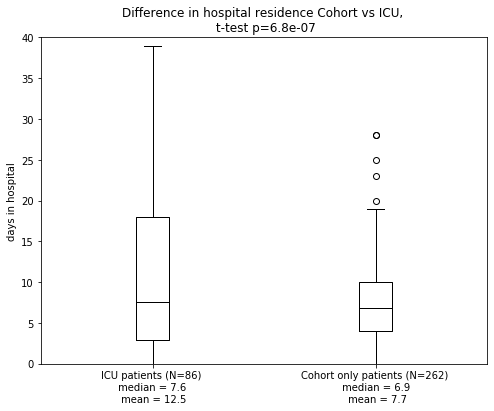

In [16]:
x = total_df[total_df.stay_type=='ICU'].dICU.dropna()
y = total_df[total_df.stay_type=='Cohort only'].dC.dropna()
stat, p = ttest_ind(x, y)
fig, ax = plt.subplots(figsize=(8,6))
bp = ax.boxplot([x, y], positions=[1,2])
plt.setp(bp['medians'], color='k')
ax.set_ylabel('days in hospital')
ax.set_ylim(0,40)
ax.set_xticklabels(['ICU patients (N={}) \n median = {:.1f} \n mean = {:.1f}'.format(len(x), x.median(), x.mean()),
                    'Cohort only patients (N={}) \n median = {:.1f} \n mean = {:.1f}'.format(len(y), y.median(), y.mean())])
ax.set_title('Difference in hospital residence Cohort vs ICU, \n t-test p={:.1e}'.format(p))
plt.savefig('test_residence_ICU_Cohort.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

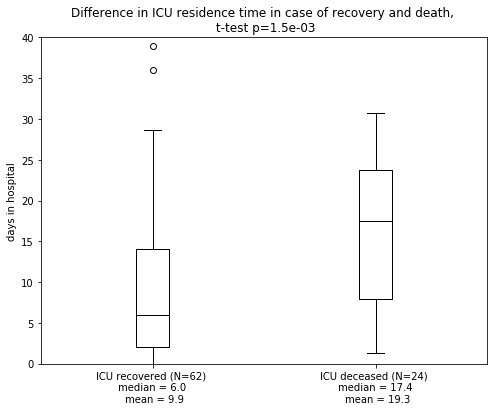

In [17]:
x = total_df[((total_df.stay_type=='ICU')&(total_df.outcome=='R'))].dICU.dropna()
y = total_df[((total_df.stay_type=='ICU')&(total_df.outcome=='D'))].dICU.dropna()
stat, p = ttest_ind(x, y)
fig, ax = plt.subplots(figsize=(8,6))
bp = ax.boxplot([x, y], positions=[1,2])
plt.setp(bp['medians'], color='k')
ax.set_ylabel('days in hospital')
ax.set_ylim(0,40)
ax.set_xticklabels(['ICU recovered (N={}) \n median = {:.1f} \n mean = {:.1f}'.format(len(x), x.median(), x.mean()),
                    'ICU deceased (N={}) \n median = {:.1f} \n mean = {:.1f}'.format(len(y), y.median(), y.mean())])
ax.set_title('Difference in ICU residence time in case of recovery and death, \n t-test p={:.1e}'.format(p))
plt.savefig('test_residence_ICU_R_D.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

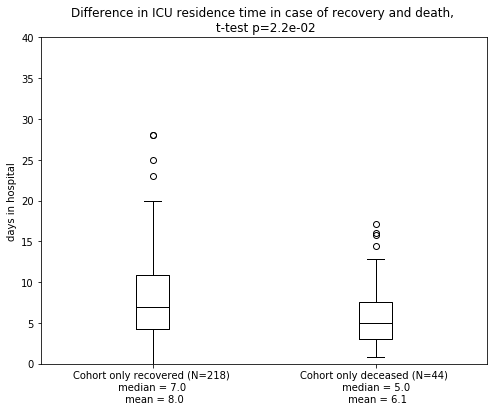

In [18]:
x = total_df[((total_df.stay_type=='Cohort only')&(total_df.outcome=='R'))].dC.dropna()
y = total_df[((total_df.stay_type=='Cohort only')&(total_df.outcome=='D'))].dC.dropna()
stat, p = ttest_ind(x, y)
fig, ax = plt.subplots(figsize=(8,6))
bp = ax.boxplot([x, y], positions=[1,2])
plt.setp(bp['medians'], color='k')
ax.set_ylabel('days in hospital')
ax.set_ylim(0,40)
ax.set_xticklabels(['Cohort only recovered (N={}) \n median = {:.1f} \n mean = {:.1f}'.format(len(x), x.median(), x.mean()),
                    'Cohort only deceased (N={}) \n median = {:.1f} \n mean = {:.1f}'.format(len(y), y.median(), y.mean())])
ax.set_title('Difference in ICU residence time in case of recovery and death, \n t-test p={:.1e}'.format(p))
plt.savefig('test_residence_Cohort_R_D.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')